# Project 




> Welcome to my project! I wanted this project to be a connection of some of the topics we learned in this class to my other major: Industrial Engineering. While looking over Kaggle, I came across this dataset: [Casting Product Image Data for Quality Inspection](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product). This dataset possesses 7348 images of submersible pump impellers; 715 images belong to an already-augmented training set while 6633 images belong to the testing set. Due to this metal casting process, several impellers are defective. As the identification of defective industrial products is critical to many projects (such as determining if a manufacturing process is in statistical control or is capable) undertaken by industrial engineers, I thought automating this identification is a worthy endeavor to follow. 



> I utilized two classification methods in this project: k-Nearest Neighbors with SVD-reduced data and a Convolutional Neural Network architecture. I chose these two methods as I thought they provided different approaches in distinguishing defective from non-defective items. 






## Initializing and Uploading Stuff



> Let us first import everything we need and upload our data. 



In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



> Now, it is time to upload our data! We will use a Kaggle API key to download the dataset of images from Kaggle to Colab. 



In [ ]:
!pwd

/content


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

real-life-industrial-dataset-of-casting-product.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip '/content/real-life-industrial-dataset-of-casting-product'.zip -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: /content/casting_data/casting_data/train/def_front/cast_def_0_5282.jp



> Next, we will obtain Director Iterators of the training and testing set through the use of Keras's ImageDataGenerator. Firstly, ImageDataGenerator will scale our pixel values to from [0,255] to [0,1]. Then, we will use the flow_from_directory method to load our data as variables in our code. I have set the color_mode to grayscale (1 color channel) as the images are already in grayscale. However, if I do not specify this, we will obtain image arrays of shape (Pixels, Pixels, 3). I set the class_mode to binary as we are dealing with binary data: defective and ok parts. I set the batch sizes of the two directory iterators to our anticipated sizes of our training and testing sets (6633 and 715, respectively). Honestly, this is due to my own inexperience with this method. I was unable to directly load every image from the directory iterators with batch sizes less than their expected sizes. 



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

training_set = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/casting_data/casting_data/train',
                                                        color_mode='grayscale',
                                                        class_mode='binary',
                                                        batch_size=6633,
                                                        seed=42)
testing_set = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/casting_data/casting_data/test',
                                                        color_mode='grayscale',
                                                        class_mode='binary',
                                                        batch_size=715,
                                                        seed=42)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.




> The next function allowed me to segment our directory iterators into training and testing arrays. While I know one can use these iterators as inputs of the CNN model, I opted for this (probably less sophisticated) approach due to my familiarity.



In [ ]:
x_train, y_train = next(training_set) 
x_test, y_test = next(testing_set)   



> I saved the size of the training set, testing set, and image resolution (6633, 715, and 256) for further ease.



In [ ]:
n_train = len(x_train)
n_test = len(x_test)
orig_dim = len(x_train[0])



> The below reshaping results in our images being of shape (256, 256) rather than (256,256,1). We will reshape these images further for SVD.



In [ ]:
x_train_SVD = x_train.reshape((n_train,orig_dim,orig_dim))
x_test_SVD = x_test.reshape((n_test,orig_dim,orig_dim))

In [ ]:
print(np.shape(x_train_SVD), np.shape(x_test_SVD),
      y_train[0:10])

(6633, 256, 256) (715, 256, 256) [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]




> I made arrays of defective and ok items just to plot several representative images. As a result, we can see why some defective products are deemed as such (like the existence of holes through part of the main metallic alloy and roughed-up outer edges).



In [ ]:
images_of_def = x_train_SVD[(y_train==0.)]
images_of_no_def = x_train_SVD[(y_train==1.)]

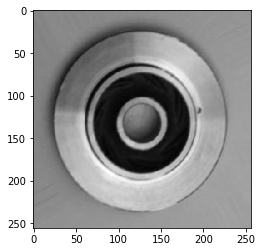

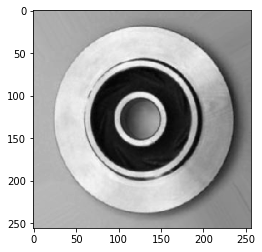

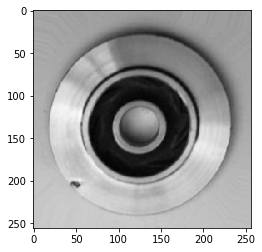

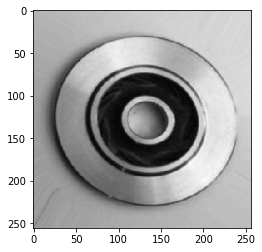

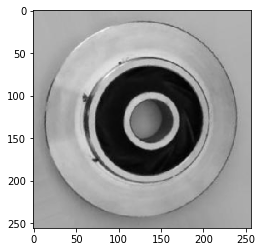

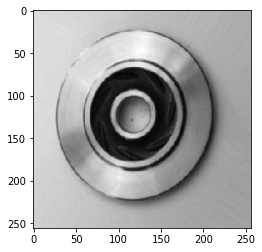

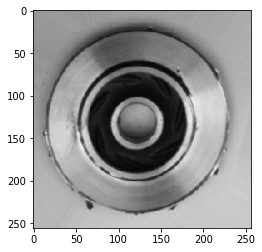

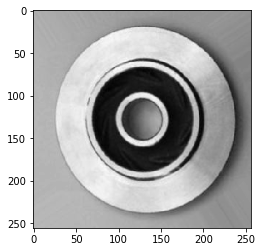

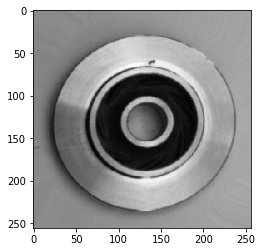

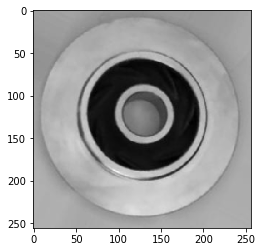

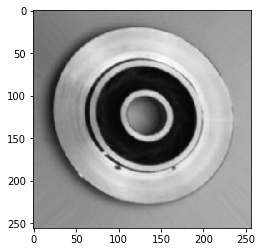

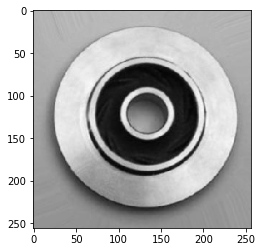

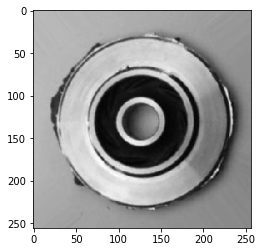

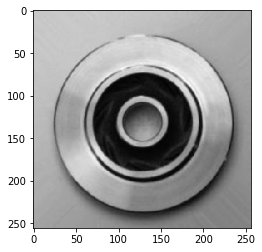

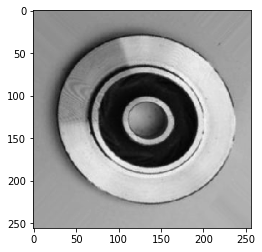

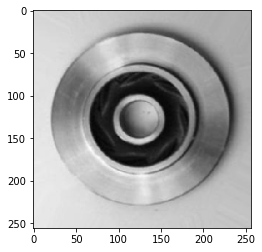

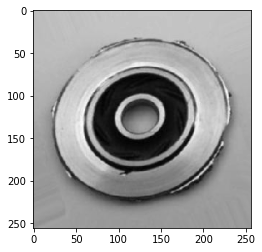

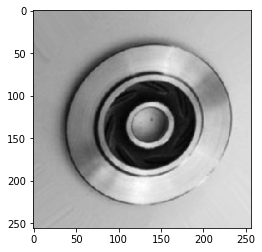

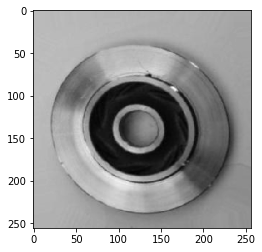

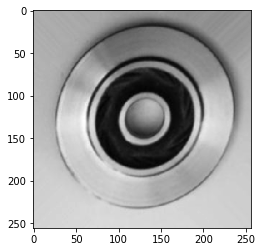

In [ ]:
for i in range(10): # just to easily compare images of products w one another
  plt.show(plt.imshow(images_of_def[i],cmap='gray'))
  plt.show(plt.imshow(images_of_no_def[i],cmap='gray'))

## SVD + kNN



> Our first method of classifying our images is to use k-Nearest Neighbors. To augment the performance of this tool, we will truncate the dimensionality of our image vectors through Singular Value Decomposition.


> We have reshaped our training and testing sets further by turning our images into vectors from R^(256*256). We will need to reduce this dimensionality of 65536 to a much more smaller value to reduce our computation time, to reduce the noise being fed to k-NN, and to prevent this Colab from crashing due to a lack of free memory. 





In [ ]:
x_train_vec = x_train_SVD.reshape((n_train,orig_dim**2))
x_test_vec = x_test_SVD.reshape((n_test,orig_dim**2))

In [ ]:
print(np.shape(x_train_vec))

(6633, 65536)




> Now, we would like to obtain our Sigma matrix S to identify what dimensionality our images vectors should be reduced to. We would like to choose enough singular values to represent a vast majority (say above 85%) of our data. 


> If we attempted to use linalg.svd, we would have experienced a taxing computation time as well as our notebook crashing from a lack of memory. As such, I opted to use randomized_svd to obtain a rough approximation of our targeted matrix S. As we (most likely) do not need all of our 65536 singular values to capture the information found in our images, I only requested a S matrix of just 1000 singular values. I then used Professor Wagner's nice_general_svd to pad S with zeros so that it is a square matrix (note: this was ultimately unnecessary for us, but this did not worsen our computation time by much). 





In [ ]:
from scipy.linalg import diagsvd
from sklearn.utils.extmath import randomized_svd

def nice_general_svd(R):        
  _,S,_ = randomized_svd(R, n_components=1000, n_iter=5,
                          random_state=None)
  S = diagsvd(S, 6633, 1000) # to pad our S 
  return S

In [ ]:
S = nice_general_svd(x_train_vec) # to figure out how much to reduce our data to



> Ok! Let us see how much data we can fit into a smaller number of dimensions. We can determine this number by looking at a plot of S's diagonal values (the singular values).


> Just as we suspected: our original dimensionality of 65536 can be reduced to a much, much smaller number. Let us look at a zoomed-in plot. 





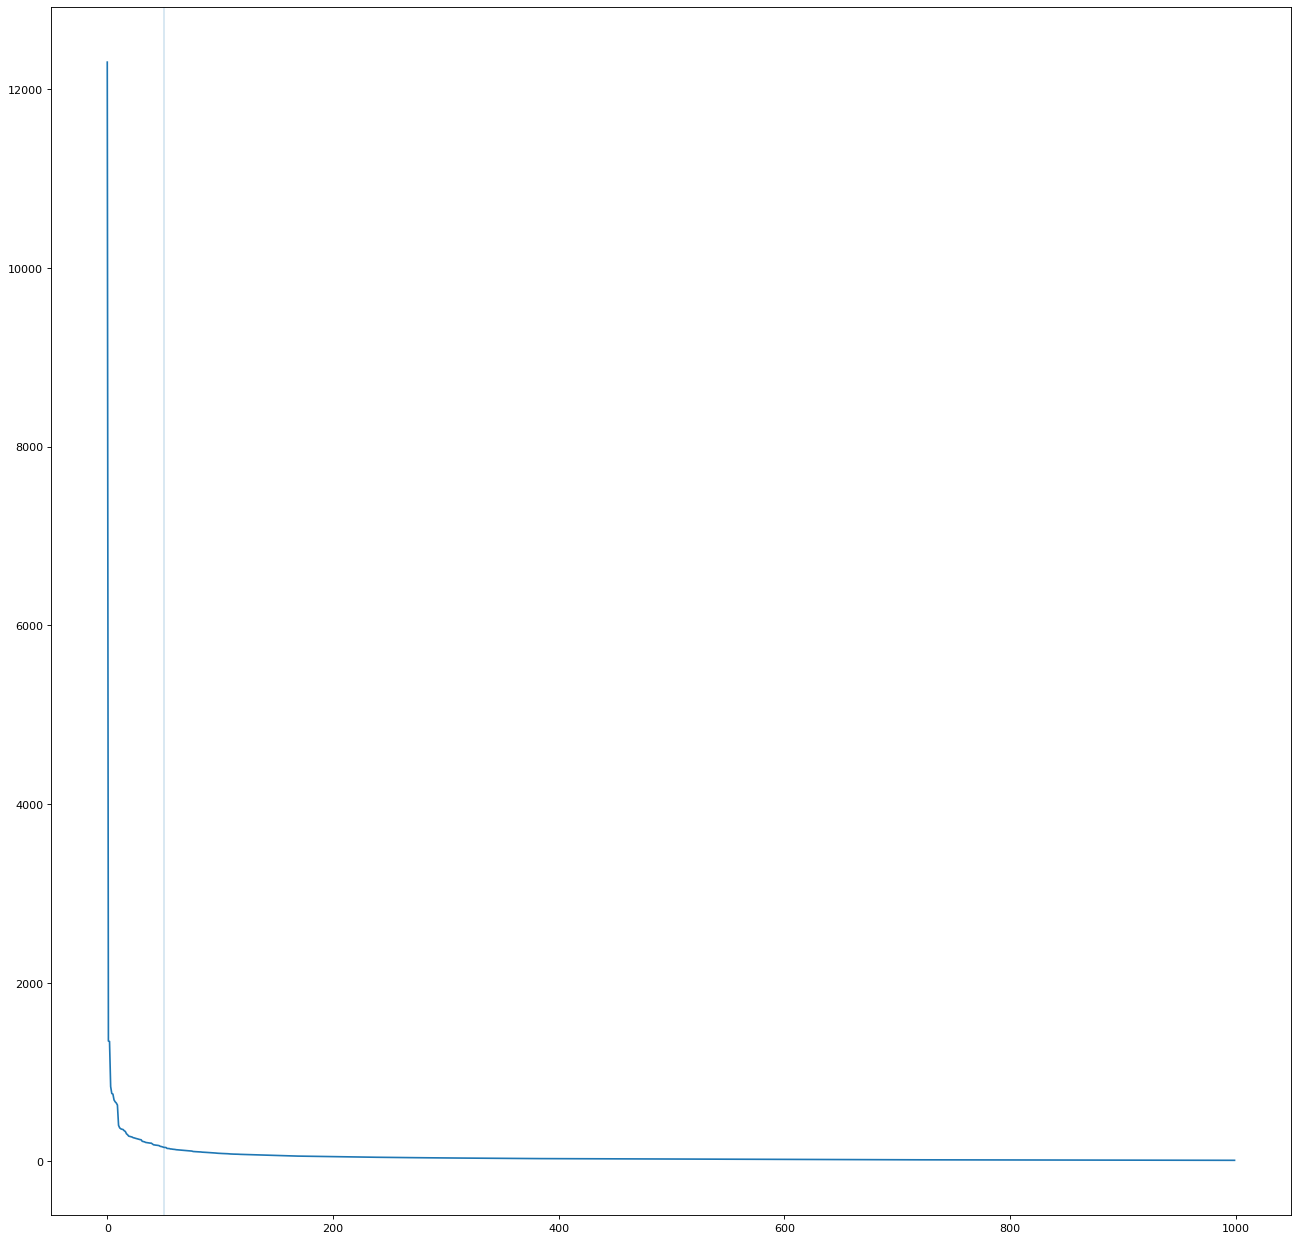

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=80)
plt.plot(np.diagonal(S))                 
plt.axvline(x = 50, alpha = 0.2)

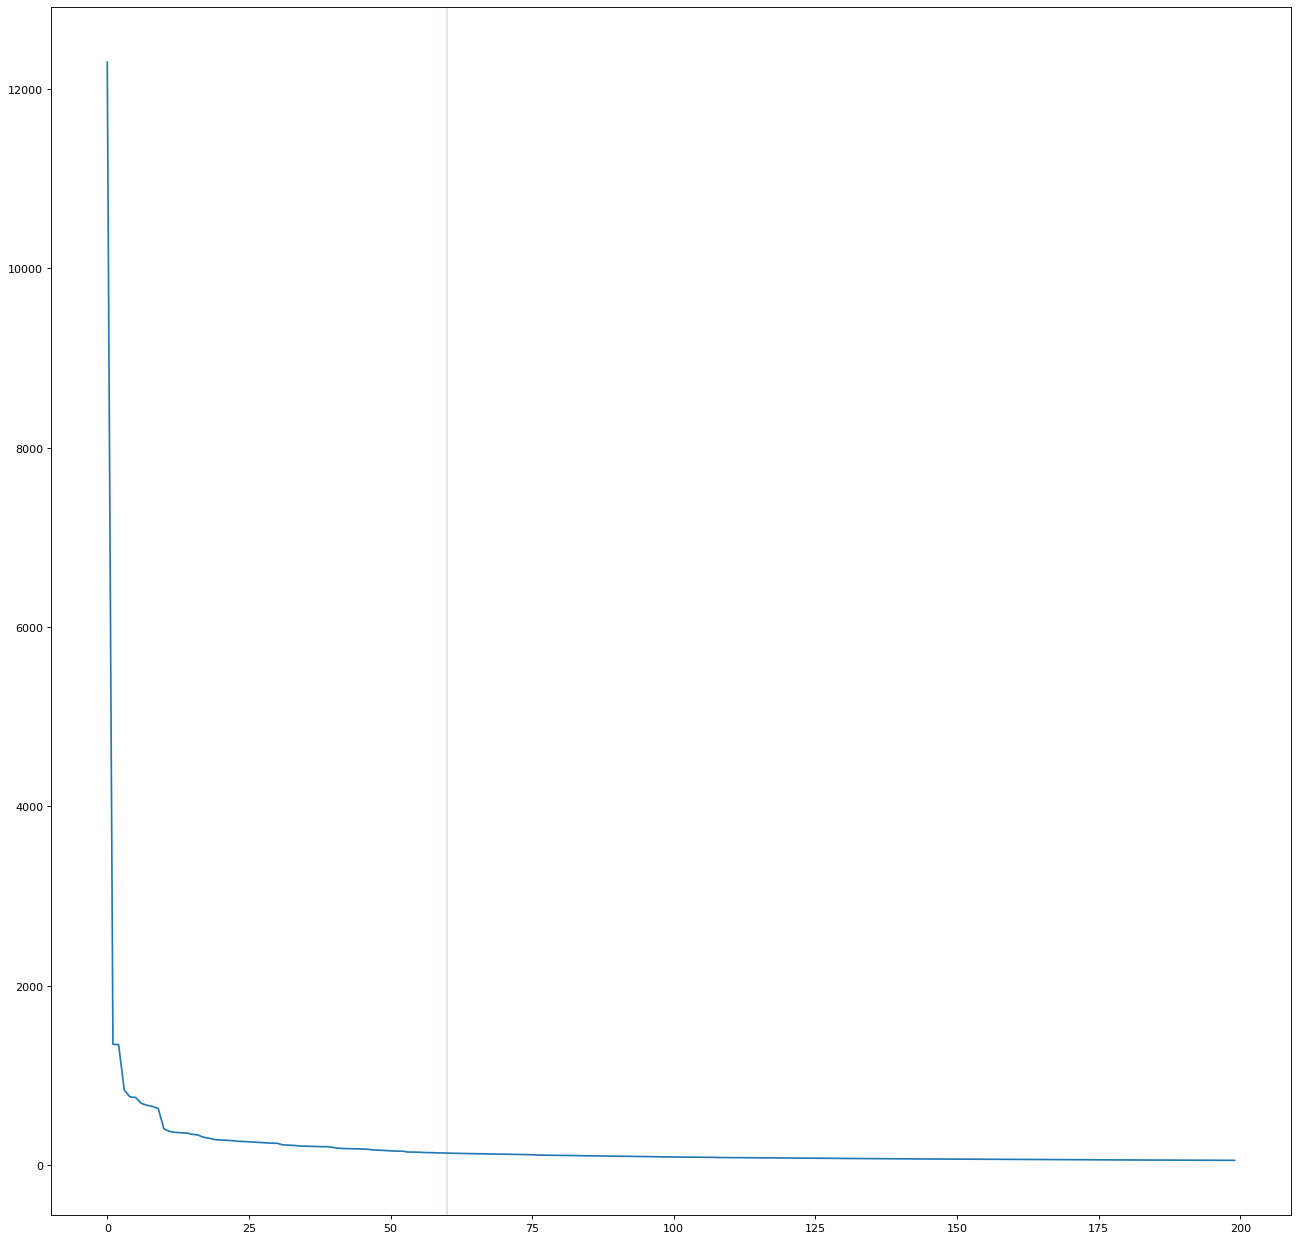

In [ ]:
figure(figsize=(20, 20), dpi=80) # 'zooming' in 
plt.plot(np.diagonal(S[:200]))                 
plt.axvline(x = 60, alpha = 0.2)



> This is an arbitrary pick, but let us reduce our images' dimensionality to 60. I chose this value as it appeared to be a figure well past the start of the "asymptote around x = 0" phase of the singular values plot. 


> We will use the TruncatedSVD function to return our reduced training and testing sets. This function will conduct an approximated Singular Value Decomposition of our training data with just 60 singular values. Then, we will transform the bases of our two data sets to vectors from R^60. From this, we can move onto k-NN.





In [ ]:
red_SVD = TruncatedSVD(n_components=60)
x_train_red = red_SVD.fit_transform(x_train_vec)
x_test_red = red_SVD.transform(x_test_vec)



> This is a spoiler, but we will get a near-perfect accuracy with k-NN at k = 1. Due to my skepticism, I ran a 5-fold cross validation of our entire dataset of reduced-dimension images to determine an optimal pick of the number of neighbors k for k-NN and to verify our (future) results.



In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
X_SVD = np.vstack((x_train_red,x_test_red)) # this is for cross-validation down
Y_SVD = np.vstack((y_train.reshape(-1,1),y_test.reshape(-1,1))) # below



> As shown below, k = 1 is our optimal value. This value returns the largest Cross-Validation accuracy out of the first 101 number of neighbors. 



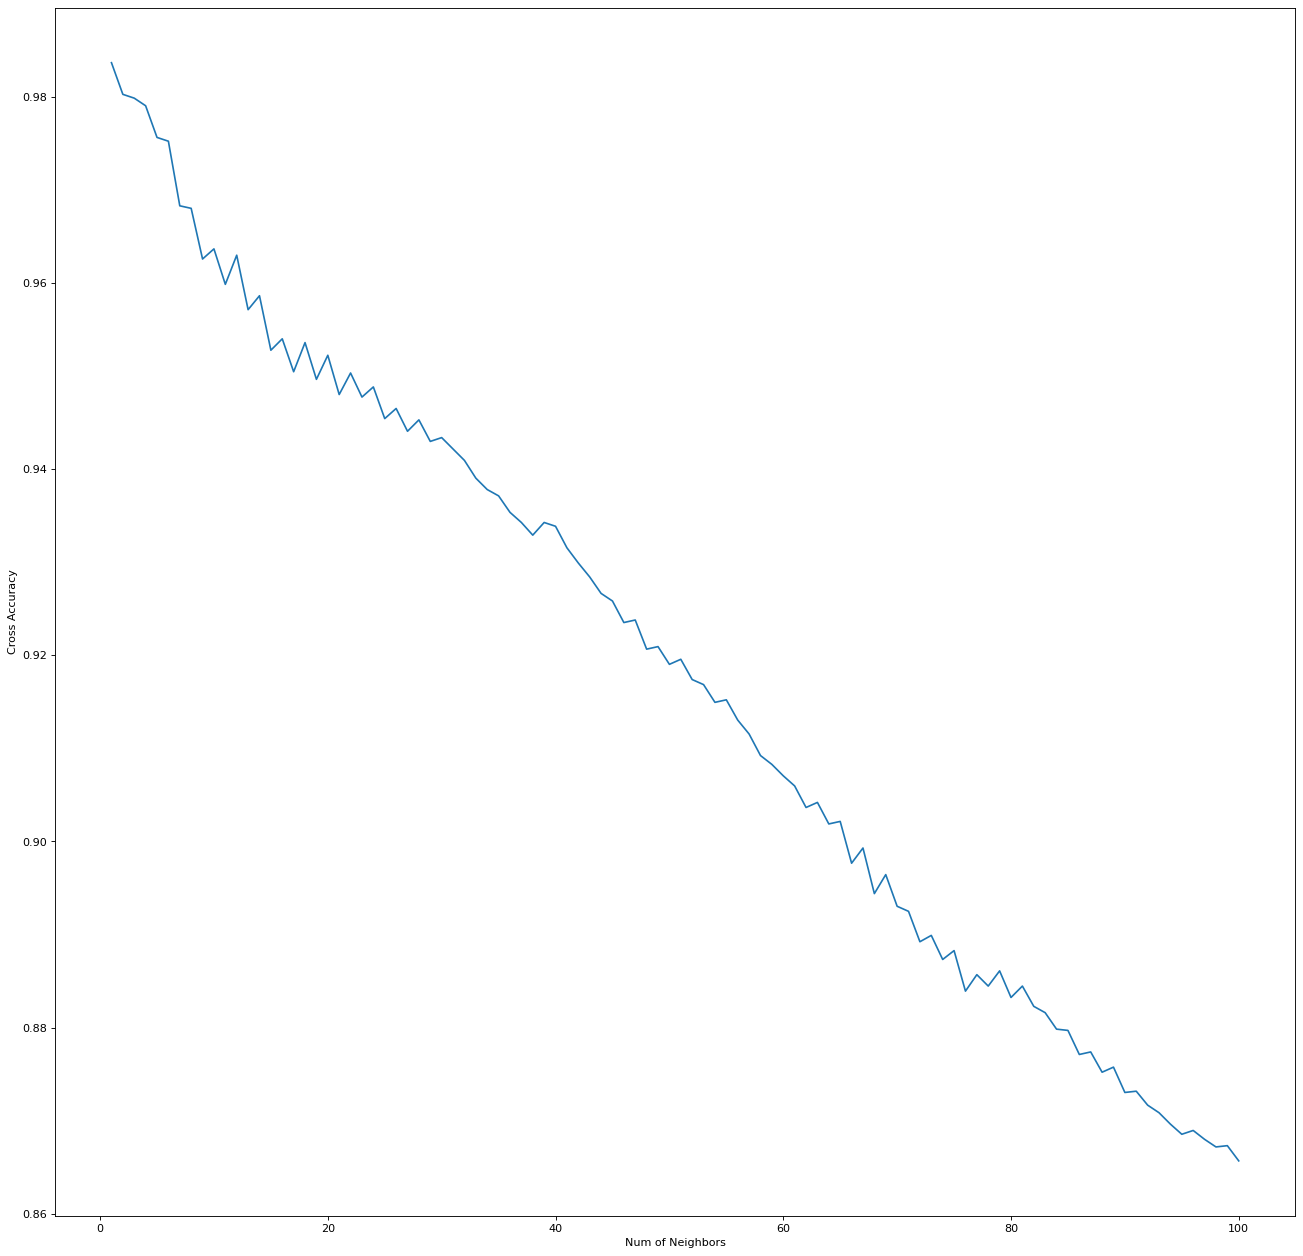

In [ ]:
figure(figsize=(20, 20), dpi=80)
cross_score = []
for i in range(1, 101):
    knn = KNeighborsClassifier(n_neighbors=i)
    my_score = cross_val_score(knn, X_SVD, Y_SVD.ravel(), 
                               cv=5, scoring='accuracy')
    cross_score.append(my_score.mean())
# plot to see clearly
plt.plot(range(1, 101), cross_score)
plt.xlabel('Num of Neighbors')
plt.ylabel('Cross Accuracy')
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train_red,y_train)
my_pred = knn.predict(x_test_red)
acc = accuracy_score(y_test, my_pred)
print(f'acc: {acc*100}%')

acc: 98.88111888111888%


In [ ]:
print(classification_report(y_test,my_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       453
         1.0       0.97      1.00      0.98       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [ ]:
print(confusion_matrix(y_test,my_pred))

[[446   7]
 [  1 261]]




> We got an accuracy of ~98.9% with the use of just 60 basis vectors from SVD and one neighbor in kNN. This is fantastic news for us! However, could we achieve a better result with the help of a CNN model? Let us find out in the next section.





> Throughout several runs of this notebook, I experienced many (frustrating) notebook crashes in the CNN section of the project due to a lack of free RAM. This resulted in me starting from scratch, something demoralizing and too time-intensive. To best mitigate the likelihood of this notebook crashing during the fitting of training data by this CNN, I deleted several variables I knew I would not use later in this project. Thankfully (or maybe due to wishful thinking or a placebo effect, of sorts), my notebook did not crash when running the CNN section of my code. 



In [ ]:
del x_train_red, x_train_vec, x_train_SVD, x_test_red, x_test_SVD, x_test_vec
del my_pred, knn, my_score, S, red_SVD, X_SVD, Y_SVD, acc, images_of_def, images_of_no_def

## CNN



> We will see if we can achieve an accuracy greater than 98.88% (without overfitting) through the use of a CNN architecture. We will see if our model overfits our training data by observing the cross-validation accuracy obtained at each epoch. If this accuracy is as large (or even larger) as our regular accuracy, then I can state with confidence that we did encounter overfitting in our model.





> Let us change our label arrays to "one-hot" arrays that can be better understood by our CNN model. 



In [ ]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)



> Below is our massive CNN model. I played around the number of filters at each convolution and dense layer to see what can result in an accurate (>98.9%) model. The first dense layer is responsible for most of the model's ~3.2 million parameters. I wonder if this will affect our computation speed and our cross-validation accuracy. 



In [ ]:
model = keras.models.Sequential()

model.add(keras.Input(shape=(orig_dim, orig_dim, 1)))


model.add(keras.layers.Conv2D(filters = 8, kernel_size = (3,3), 
                              use_bias = False, 
                              padding = 'same'))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(keras.layers.Conv2D(filters = 16, kernel_size = (3,3), 
                              use_bias = False, 
                              padding = 'same'))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(keras.layers.Conv2D(filters = 16, kernel_size = (3,3), 
                              use_bias = False, 
                             padding = 'same'))

model.add(keras.layers.Activation('relu'))

model.add(keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(196, use_bias=False))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Dense(2, use_bias=False))

model.add(keras.layers.Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 8)       72        
                                                                 
 activation_5 (Activation)   (None, 256, 256, 8)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      1152      
                                                                 
 activation_6 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                  



> Well, we did it. It took 27 minutes to run our model across 8 epochs, but we ultimately obtained an accuracy of 99.2% and a cross-validation accuracy of 99.44%. I think this small boost in accuracy is worth it for two reasons. If we produce a massive amount of impellers at a given time, this ~0.5% shift can prevent us from discarding many non-defective products and accepting many defective products. The latter action can result in serious harm done to those consumers of these products. Secondly, getting an increase in accuracy, while ensuring our cross-validation accuracy was as high, was a huge morale boost. I spent so many times running a variation of this model only to encounter a final accuracy of 82% or this notebook crashing.


In [ ]:
model.fit(x_train, y_train_cat, epochs = 8, 
          validation_data = (x_test,y_test_cat))


Epoch 1/8
208/208 [==============================] - 205s 981ms/step - loss: 0.5595 - accuracy: 0.7028 - val_loss: 0.6432 - val_accuracy: 0.6462
Epoch 2/8
208/208 [==============================] - 204s 981ms/step - loss: 0.3427 - accuracy: 0.8453 - val_loss: 0.1908 - val_accuracy: 0.9301
Epoch 3/8
208/208 [==============================] - 205s 984ms/step - loss: 0.1737 - accuracy: 0.9323 - val_loss: 0.1245 - val_accuracy: 0.9497
Epoch 4/8
208/208 [==============================] - 205s 986ms/step - loss: 0.0980 - accuracy: 0.9659 - val_loss: 0.1733 - val_accuracy: 0.9329
Epoch 5/8
208/208 [==============================] - 204s 982ms/step - loss: 0.0734 - accuracy: 0.9745 - val_loss: 0.1040 - val_accuracy: 0.9538
Epoch 6/8
208/208 [==============================] - 209s 1s/step - loss: 0.0604 - accuracy: 0.9798 - val_loss: 0.0485 - val_accuracy: 0.9888
Epoch 7/8
208/208 [==============================] - 205s 983ms/step - loss: 0.0600 - accuracy: 0.9799 - val_loss: 0.0267 - val_accur

In [ ]:
y_predicted_proba = model.predict(x_test)

In [ ]:
y_predicted_labels = np.argmax(y_predicted_proba, axis = 1)

In [ ]:
acc = np.mean(y_predicted_labels == y_test)

In [ ]:
print(f'test accuracy: {acc}')

test accuracy: 0.9944055944055944


## In Summary



> We sought to distinguish defective metal impellers from non-defective ones. To do so, we utilized k-NN fed with truncated SVD data and a CNN network of 3.3 million parameters. k-NN returned an admirable accuracy of 98.88%. The CNN model returned an accuracy of 99.2% with a cross-validation accuracy of 99.44%. I believe the latter model should be used over the former due to how important a difference 0.5% can be in manufacturing. 



## Random Remarks About the Project




> I wanted this section to clear up some difficulties and details in this project. 



*   In an earlier version of this notebook, kNN had an accuracy of around 90% and CNN had an max accuracy of 82%. I realized I made a mistake when loading the data from the director from the notebook. The training data had come from the testing folder while the testing data had come from the training folder! This really made things difficult, but thankfully I was able to revise things.
*   Unfortunately, my CNN model remained inaccurate despite me changing the number of filters at each layer. I realized that a possible culprit was the use of non-scaled image data. I originally loaded this data to seperate training and testing sets unscaled, so I can utilize the EfficientNetb0 model [this data was also of shape (224, 224, 3)]. I thought I was able to scale the images to [0,1] for the CNN model outside of this data loading code. However, my notebook crashed every time I created new arrays equal to the (EfficientNetb0 data / 255.). There is an StackOverflow thread discussing this problem as (EfficientNetb0 data / 255.) would produce float64 values, resulting in these crashes.
*   I originally planned to include an EfficientNetb0 model with Transfer Learning in this project as stated above. I wanted to see how powerful this model could be (almost for fun). However, my notebook was unable to run that model with these images. Also, the custom-built CNN model is good for me.
*   Why did I separate my convolution and dense layers from my activation layers? The reason for this was due to me originally including BatchNormalization() layers before each activation layer. Unfortunately, this resulted in a stagnant, low cross-validation accuracy. In one run of just three epochs, I was able to get accuracies above 87%. However, the cross-validation accuracy at each epoch remained at 43.34%. I was unable to rectify this issue, so I removed the BatchNormalization() layers altogether from my CNN architecture. 
*   I am thankful that randomizedSVD exists. When I used linalg.svd on the 6.5k training images at a reduced resolution of 128x128, I encountered many crashes. I am unsure how things would have shaped up with resoltions equal to 256x256. 







## Helpful Links I Used:


*   https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product
*   https://stackoverflow.com/questions/62977311/how-can-i-stop-my-colab-notebook-from-crashing-while-normalising-my-images
*   https://www.youtube.com/watch?v=Gvwuyx_F-28
*   https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
*   https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
*   https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks
*   https://stackoverflow.com/questions/57457817/adding-batch-normalization-decreases-the-performance
*   https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
*   https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD.fit
*   https://datascience.stackexchange.com/questions/61036/x-train-y-train-from-imagedatagenerator-keras



